### 数据处理
需要定义继承Dataset的GloveDataset类（对训练预料处理、构建词表），同时共现矩阵的构建和存取。

In [2]:
from collections import defaultdict, Counter
class Vocab:
    def __init__(self, tokens=None):
        self.idx_to_token = list()  # 使用列表存储所有的标记，从而根据索引值获取相应的标记
        self.token_to_idx = dict()  # 使用字典实现标记到索引的映射

        if tokens is not None:
            if "<unk>" not in tokens:
                tokens = tokens + ["<unk>"]
            for token in tokens:
                self.idx_to_token.append(token) #获取id_to_token
                self.token_to_idx[token] = len(self.idx_to_token) - 1 # h获取token_to_id
            self.unk = self.token_to_idx['<unk>']

    @classmethod
    # 创建词表、输入的text包含若干句子，每个句子由若干标记构成
    def build(cls, text, min_freq=1, reserved_tokens=None):
        token_freqs = defaultdict(int)  # 存储标记及其出现次数的映射字典
        for sentence in text:
            for token in sentence: # 统计词频
                token_freqs[token] += 1
        # 无重复的标记，其中预留了未登录词汇（Unknown word）标记（<unk>）以及若干
        # 用户自定义的预留标记
        uniq_tokens = ["<unk>"] + (reserved_tokens if reserved_tokens else [])
        uniq_tokens += [token for token, freq in token_freqs.items() if freq >= min_freq and token != "<unk>"]
        return cls(uniq_tokens)

    # 返回词表的大小，即词表中有多少个互不相同的标记
    def __len__(self):
        return len(self.idx_to_token)

    # 查找输入标记对应的索引值，如果该标记不存在，则返回标记<unk>的索引值0
    def __getitem__(self, token):
        return self.token_to_idx.get(token, self.unk)

    # 查找一系输入标记对应的索引值
    def convert_tokens_to_ids(self, tokens):
        return [self[token] for token in tokens]

    #  查找一系列索引值对应的标记
    def convert_ids_to_tokens(self, indices):
        return [self.idx_to_token[index] for index in indices]


def save_vocab(vocab, path):
    with open(path, 'w') as writer:
        writer.write("\n".join(vocab.idx_to_token))


def read_vocab(path):
    with open(path, 'r') as f:
        tokens = f.read().split('\n')
    return Vocab(tokens)


In [3]:
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
from nltk.corpus import reuters  # 从nltk中导入Reuters数据处理模块


# Constants
BOS_TOKEN = "<bos>"  # 句首标记
EOS_TOKEN = "<eos>"  # 句尾标记
PAD_TOKEN = "<pad>"  # 补齐序列长度的标记
BOW_TOKEN = "<bow>"
EOW_TOKEN = "<eow>"

WEIGHT_INIT_RANGE = 0.1


def load_reuters():
    text = reuters.sents()  # 获取Reuters数据中的所有句子（已完成标记解析）
    text = [[word.lower() for word in sentence]
            for sentence in text]  # 将语料中的词转换为小写（可选）
    # 构建词表，并传入预留标记,包括idx_to_token、token_to_idx
    vocab = Vocab.build(text, reserved_tokens=[
                        PAD_TOKEN, BOS_TOKEN, EOS_TOKEN])  # 构建词表，并传入预留标记,包括idx_to_token、token_to_idx
    # 找出文本中每一个句子中单词所对应的序列
    corpus = [vocab.convert_tokens_to_ids(
        sentence) for sentence in text]  # 利用词表将文本数据转换为id表示

    return corpus, vocab


def save_pretrained(vocab, embeds, save_path):
    with open(save_path, "w") as writer:
        #记录词表大小
        writer.write(f"{embeds.shape[0]} {embeds.shape[1]}\n")
        for idx, token in enumerate(vocab.idx_to_token):
            vec = " ".join(["{:.4f}".format(x) for x in embeds[idx]])
            #每一行对应一个单词以及由空格分隔的词向量
            writer.write(f"{token} {vec}\n")
    print(f"Pretrained embeddings saved to:{save_path}")


def load_pretrained(load_path):
    with open(load_path, "r") as fin:
        n, d = map(int, fin.readline().split())
        tokens = []
        embeds = []
        for line in fin:
            line = line.rstrip().split(' ')
            token, embeds = line[0], list(map(float, line[1:]))
            tokens.append(token)
            embeds.append(embeds)
        vocab = Vocab(tokens)
        embeds = torch.tensor(embeds, dtype=torch.float)
    return vocab, embeds


def get_loader(dataset, batch_size, shuffle=True):
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        collate_fn=dataset.collate_fn,
        shuffle=shuffle  # 打乱数据顺序
    )
    return data_loader


def init_weights(model):
    for name, param in model.named_parameters():
        # print("------------------------------------------------------")
        # print("model.named_parameters()",model.named_parameters())
        if "embedding" not in name:
            torch.nn.init.uniform_(
                param, a=-WEIGHT_INIT_RANGE, b=WEIGHT_INIT_RANGE)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from tqdm.auto import tqdm
from collections import defaultdict

class GloveDataset(Dataset):
    def __init__(self, corpus, vocab, context_size=2):
        # 记录词与上下文在给定语料中的共现次数
        self.cooccur_counts = defaultdict(float)
        self.bos = vocab[BOS_TOKEN]  # 句首标记
        self.eos = vocab[EOS_TOKEN]  # 句尾标记
        for sentence in tqdm(corpus, desc="Dataset Construction"):
            sentence = [self.bos] + sentence + [self.eos]
            for i in range(1, len(sentence)-1):
                w = sentence[i]
                left_contexts = sentence[max(0, i - context_size):i]
                right_contexts = sentence[i+1:min(len(sentence), i + context_size)+1]
                # 共现次数随距离衰减: 1/d(w, c)
                for k, c in enumerate(left_contexts[::-1]):
                    self.cooccur_counts[(w, c)] += 1 / (k + 1)
                for k, c in enumerate(right_contexts):
                    self.cooccur_counts[(w, c)] += 1 / (k + 1)
        self.data = [(w, c, count) for (w, c), count in self.cooccur_counts.items()]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]

    def collate_fn(self, examples):
        words = torch.tensor([ex[0] for ex in examples])
        contexts = torch.tensor([ex[1] for ex in examples])
        counts = torch.tensor([ex[2] for ex in examples])
        return (words, contexts, counts)


## 模型部分
Glove比负采样的skip-gram模型增加两个偏置变量w_biased和c_biases变量。

In [5]:
class GloveModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(GloveModel, self).__init__()
        # 词嵌入及偏置向量
        self.w_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.w_biases = nn.Embedding(vocab_size, 1)
        # 上下文嵌入及偏置向量
        self.c_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.c_biases = nn.Embedding(vocab_size, 1)

    def forward_w(self, words):
        w_embeds = self.w_embeddings(words)
        w_biases = self.w_biases(words)
        return w_embeds, w_biases

    def forward_c(self, contexts):
        # 上下文embedding和偏置向量
        c_embeds = self.c_embeddings(contexts)
        c_biases = self.c_biases(contexts)
        return c_embeds, c_biases


## 模型训练

In [6]:
import nltk
nltk.download('reuters')
nltk.download('punkt')

[nltk_data] Downloading package reuters to /usr/share/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# 3. 进行训练
embedding_dim = 64
context_size = 2
# batch_size 不宜过大，大概32左右比较合适，10个epoch就可以看到较为明显的效果
# 大batch即使训练几千个epoch效果也不明显，收敛很慢甚至不收敛
batch_size = 32
num_epoch = 200

# 用以控制样本权重的超参数
m_max = 100
alpha = 0.75

# 从文本数据中构建GloVe训练数据集
corpus, vocab = load_reuters()
dataset = GloveDataset(
    corpus,
    vocab,
    context_size=context_size
)

def get_loader(dataset, batch_size, shuffle=True):
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        collate_fn=dataset.collate_fn,
        shuffle=shuffle
    )
    return data_loader
data_loader = get_loader(dataset, batch_size)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = GloveModel(len(vocab), embedding_dim)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()
for epoch in range(num_epoch):
    total_loss = 0
    for batch in tqdm(data_loader, desc=f"Training Epoch {epoch}"):
        words, contexts, counts = [x.to(device) for x in batch]
        # 提取batch内词、上下文的向量表示及偏置
        word_embeds, word_biases = model.forward_w(words)
        context_embeds, context_biases = model.forward_c(contexts)
        # 回归目标值：必要时可以使用log(counts+1)进行平滑
        log_counts = torch.log(counts)
        # 样本权重
        weight_factor = torch.clamp(torch.pow(counts / m_max, alpha), max=1.0)
        optimizer.zero_grad()
        # 计算batch内每个样本的L2损失
        loss = (torch.sum(word_embeds * context_embeds, dim=1) + word_biases + context_biases - log_counts) ** 2
        # 样本加权损失
        wavg_loss = (weight_factor * loss).mean()
        wavg_loss.backward()
        optimizer.step()
        total_loss += wavg_loss.item()
    print(f"Loss: {total_loss:.2f}")

# 合并词嵌入矩阵与上下文嵌入矩阵，作为最终的预训练词向量
combined_embeds = model.w_embeddings.weight + model.c_embeddings.weight
save_pretrained(vocab, combined_embeds.data, "glove.vec")


## 将训练好的glove词向量可视化
`glove.vec`读取到字典里，单词为key，embedding作为value；选了几个单词的词向量进行降维，然后将降维后的数据转为dataframe格式，绘制散点图进行可视化。
可以直接使用`sklearn.manifold`的`TSNE`：
`perplexity` 参数用于控制 t-SNE 算法的困惑度，
`n_components` 参数用于指定降维后的维度数，
`init` 参数用于指定初始化方式，
`n_iter` 参数用于指定迭代次数，
`random_state` 参数用于指定随机数种子。
`ax.annotate(word, pos, fontsize = 40)`可以在每个节点位置加上对应词向量的key。

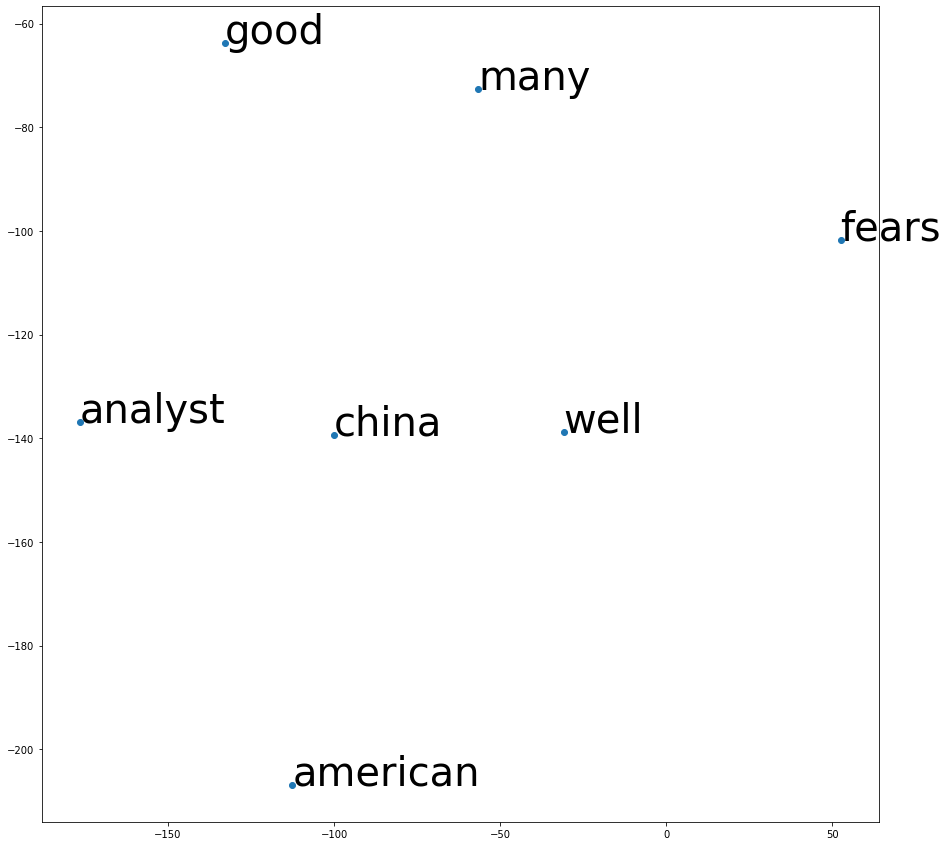

In [8]:
# !/usr/bin/python
# -*- coding: utf-8 -*-
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt

# 加载训练好的词向量
embeddings_index = {}
with open('./glove.vec', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# 选择部分词向量进行降维可视化
# words = ['apple', 'banana', 'orange', 'pear', 'grape', 'watermelon']
words = ['good', 'well', 'many', 'fears', 'american', 'analyst', 'china']
# embeddings_index_selected = {word: embeddings_index[word] for word in words}
embeddings_index_selected = np.array([embeddings_index[word] for word in words])

# 对词向量进行降维
tsne_model = TSNE(perplexity=5, n_components=2, init='pca', n_iter=2500, random_state=23)
# tsne_values = tsne_model.fit_transform(list(embeddings_index_selected.values()))
tsne_values = tsne_model.fit_transform(embeddings_index_selected)
# 将降维后的数据转换为 DataFrame 格式
df = pd.DataFrame(tsne_values, index=words, columns=['x', 'y'])
# 绘制散点图
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(df['x'], df['y'])
for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize = 40)

plt.savefig("glove_embedding_tsne.jpg")
plt.show()


很多时候为了更加直观比较，修改n_components=3降维到三维立体图中：

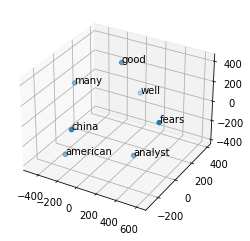

In [9]:
# 对词向量进行降维, 降为3维用于三维空间
tsne_model = TSNE(perplexity=5,
                  n_components=3, # start: 2
                  init='pca',
                  n_iter=2500,
                  random_state=23)
# tsne_values = tsne_model.fit_transform(list(embeddings_index_selected.values()))
tsne_values = tsne_model.fit_transform(embeddings_index_selected)

# (1) 3D tsne
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(tsne_values[:, 0], tsne_values[:, 1], tsne_values[:, 2])
for i, word in enumerate(words): # 添加标签
    ax.text(tsne_values[i, 0], tsne_values[i, 1], tsne_values[i, 2], word)
plt.savefig("glove_embedding_tsne_3d.jpg")
plt.show()


## 词向量评估与应用
如上面的可视化对词向量可视化比较
对词向量计算cos相似度、spearman相关系数、pearson相关系数等
预训练词向量可以直接用于下游任务，也可作为模型参数在下游任务的训练过程中进行精调（fine-tuning）
很多使用如情感分析、词性标注任务中，我们的NLP模型使用了随机初始化的词向量层（将离散词embedding化），我们其实也可以使用上面预训练好的词向量，一般能加速模型收敛、提升模型准确度
下游任务的训练数据的词表和预训练的词表一般不同，所以可以只初始化在预训练词表中存在的词，其他词仍是随机初始化向量，后续fine-tuning；其他词也可以统一用<unk>代替
有的任务中可以通过requires_gradient=False冻结词向量参数，即词向量作为特征使用
词向量的最近邻topK检索可以用如下的knn，也可以用gpu加速的faiss


In [10]:
def load_pretrained(load_path):
    with open(load_path, "r") as fin:
        # Optional: depending on the specific format of pretrained vector file
        n, d = map(int, fin.readline().split())
        tokens = []
        embeds = []
        for line in fin:
            line = line.rstrip().split(' ')
            token, embed = line[0], list(map(float, line[1:]))
            tokens.append(token)
            embeds.append(embed)
        vocab = Vocab(tokens)
        embeds = torch.tensor(embeds, dtype=torch.float)
    return vocab, embeds

def knn(W, x, k):
    similarities = torch.matmul(x, W.transpose(1, 0)) / (torch.norm(W, dim=1) * torch.norm(x) + 1e-9)
    knn = similarities.topk(k=k)
    return knn.values.tolist(), knn.indices.tolist()

# 在词向量空间中进行近义词检索(这里我们用到我们之前glove.py训练好的glove.vec，预训练词向量)
def find_similar_words(embeds, vocab, query, k=10):
    knn_values, knn_indices = knn(embeds, embeds[vocab[query]], k + 1)
    knn_words = vocab.convert_ids_to_tokens(knn_indices)
    print(f">>> Query word: {query}")
    for i in range(k):
        print(f"cosine similarity={knn_values[i + 1]:.4f}: {knn_words[i + 1]}")

word_sim_queries = ['good', 'well', 'many', 'fears', 'american', \
         'analyst', 'china', 'apple', 'banana', 'orange', 'grape', 'watermelon']

vocab, embeds = load_pretrained("glove.vec")

for w in word_sim_queries:
    find_similar_words(embeds, vocab, w)
    print("=======test========")


>>> Query word: good
cosine similarity=0.6079: very
cosine similarity=0.5297: fukukawa
cosine similarity=0.5181: seen
cosine similarity=0.5080: yet
cosine similarity=0.5016: generally
cosine similarity=0.4985: helmerich
cosine similarity=0.4927: then
cosine similarity=0.4922: despite
cosine similarity=0.4920: prospects
cosine similarity=0.4892: dissatisfaction
=======test========
>>> Query word: well
cosine similarity=0.6764: still
cosine similarity=0.6742: being
cosine similarity=0.6653: likely
cosine similarity=0.5816: indictment
cosine similarity=0.5664: move
cosine similarity=0.5622: become
cosine similarity=0.5569: make
cosine similarity=0.5541: seen
cosine similarity=0.5472: offered
cosine similarity=0.5398: back
=======test========
>>> Query word: many
cosine similarity=0.6389: several
cosine similarity=0.5681: say
cosine similarity=0.5658: how
cosine similarity=0.5543: might
cosine similarity=0.5383: economists
cosine similarity=0.5342: need
cosine similarity=0.5299: cormier
co